# Multiple Results Analysis

This notebook is intended to read a simulation results file with multiple simulations and results and create aggregate analyses and visualizations.

**Goal**:

1. Raft doesn't commit forks 
2. Raft accepts first seen 
3. Eventual chooses raft then latest

**Experimental control variables:**

- _increasing WAN latency, e.g. T (tick)_
- increasing number of nodes
- increasing amounts of failure

**Metrics:**

- number of forks
- number of stale reads
- percent visible (for full replication)
- percent committed
- number of messages
- read latency
- write latency
- visibility latency
- commit latency

In [1]:
%load_ext memory_profiler
%matplotlib inline

import os
import sys 
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import graph_tool.all as gt
import matplotlib.pyplot as plt

from operator import itemgetter
from itertools import groupby, chain
from collections import defaultdict, Counter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.colors import ColorMap
from cloudscope.results import Results
from cloudscope.results.graph import extract_graph
from cloudscope.results.analysis import create_per_replica_dataframe as create_replica_dataframe
from cloudscope.results.analysis import create_per_experiment_dataframe as create_dataframe

In [103]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('Set1')

In [3]:
# Specify a path to a results file 
# If None, will attempt to look one up
FIXTURES = os.path.join("..", "fixtures", "results")
FIGURES  = os.path.join("..", "fixtures", "figures")
# RESULTS  = os.path.join(FIXTURES, "federated-multi-original-1user-bailis.json")
# RESULTS  = os.path.join(FIXTURES, "federated-multi-original-1user-howard.json")
# RESULTS  = os.path.join(FIXTURES, "federated-multi-realism-bailis.json")
RESULTS  = os.path.join(FIXTURES, "federated-multi-users-bailis-howard.json")
RESULTS  = os.path.join(FIXTURES, "conflict-experiment.json")


def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        for line in f:
            result = json.loads(line)
            yield Results(**result)

In [4]:
%%memit 
df = create_dataframe(get_results_data())

peak memory: 389.64 MiB, increment: 263.30 MiB


In [5]:
# Uncomment below if you need to see the columns
# print("\n".join(df.columns))

# Add the ename to identify the experiment
# df['ename'] = "users = " + df['users'].apply(str) + " " + df['T parameter model']
df['ename'] = "Pc = " + df['conflict probability'].apply(str) + " " + df['T parameter model']
df['type']  = df['type'].apply(lambda s: s.title())

In [6]:
df

,T parameter model,anti-entropy delay (ms),committed writes,completed reads,completed writes,conflict probability,dropped writes,eid,"election timeout (ms, ms)",empty reads,...,stale reads,standard deviation of latency (ms),tick metric (T),type,unforked writes,users,visible writes,writes,inconsistent writes,ename
0,bailis,2500,0.0,27124,20055,0.0,0.0,e00,"[10000, 20000]",842,...,0.0,20,10000,Eventual,0.0,20,19,20055,0.0,Pc = 0.0 bailis
1,bailis,2500,0.0,27485,20069,0.1,0.0,e01,"[10000, 20000]",467,...,2402.0,20,10000,Eventual,0.0,20,13,20069,1033.0,Pc = 0.1 bailis
2,bailis,2500,0.0,27653,20101,0.2,0.0,e02,"[10000, 20000]",268,...,3846.0,20,10000,Eventual,0.0,20,16,20101,1555.0,Pc = 0.2 bailis
3,bailis,2500,0.0,27725,20111,0.3,0.0,e03,"[10000, 20000]",190,...,4796.0,20,10000,Eventual,0.0,20,8,20111,1816.0,Pc = 0.3 bailis
4,bailis,2500,0.0,27756,20118,0.4,0.0,e04,"[10000, 20000]",153,...,5567.0,20,10000,Eventual,0.0,20,8,20118,2072.0,Pc = 0.4 bailis
5,bailis,2500,0.0,27781,20119,0.5,0.0,e05,"[10000, 20000]",131,...,6333.0,20,10000,Eventual,0.0,20,8,20119,2185.0,Pc = 0.5 bailis
6,bailis,2500,0.0,27774,20119,0.6,0.0,e06,"[10000, 20000]",140,...,7560.0,20,10000,Eventual,0.0,20,9,20119,2361.0,Pc = 0.6 bailis
7,bailis,2500,0.0,27797,20118,0.7,0.0,e07,"[10000, 20000]",122,...,8544.0,20,10000,Eventual,0.0,20,11,20118,2514.0,Pc = 0.7 bailis
8,bailis,2500,0.0,27823,20121,0.8,0.0,e08,"[10000, 20000]",91,...,9181.0,20,10000,Eventual,0.0,20,9,20121,2682.0,Pc = 0.8 bailis
9,bailis,2500,0.0,27860,20123,0.9,0.0,e09,"[10000, 20000]",51,...,9777.0,20,10000,Eventual,0.0,20,10,20123,2789.0,Pc = 0.9 bailis


peak memory: 389.27 MiB, increment: 0.00 MiB


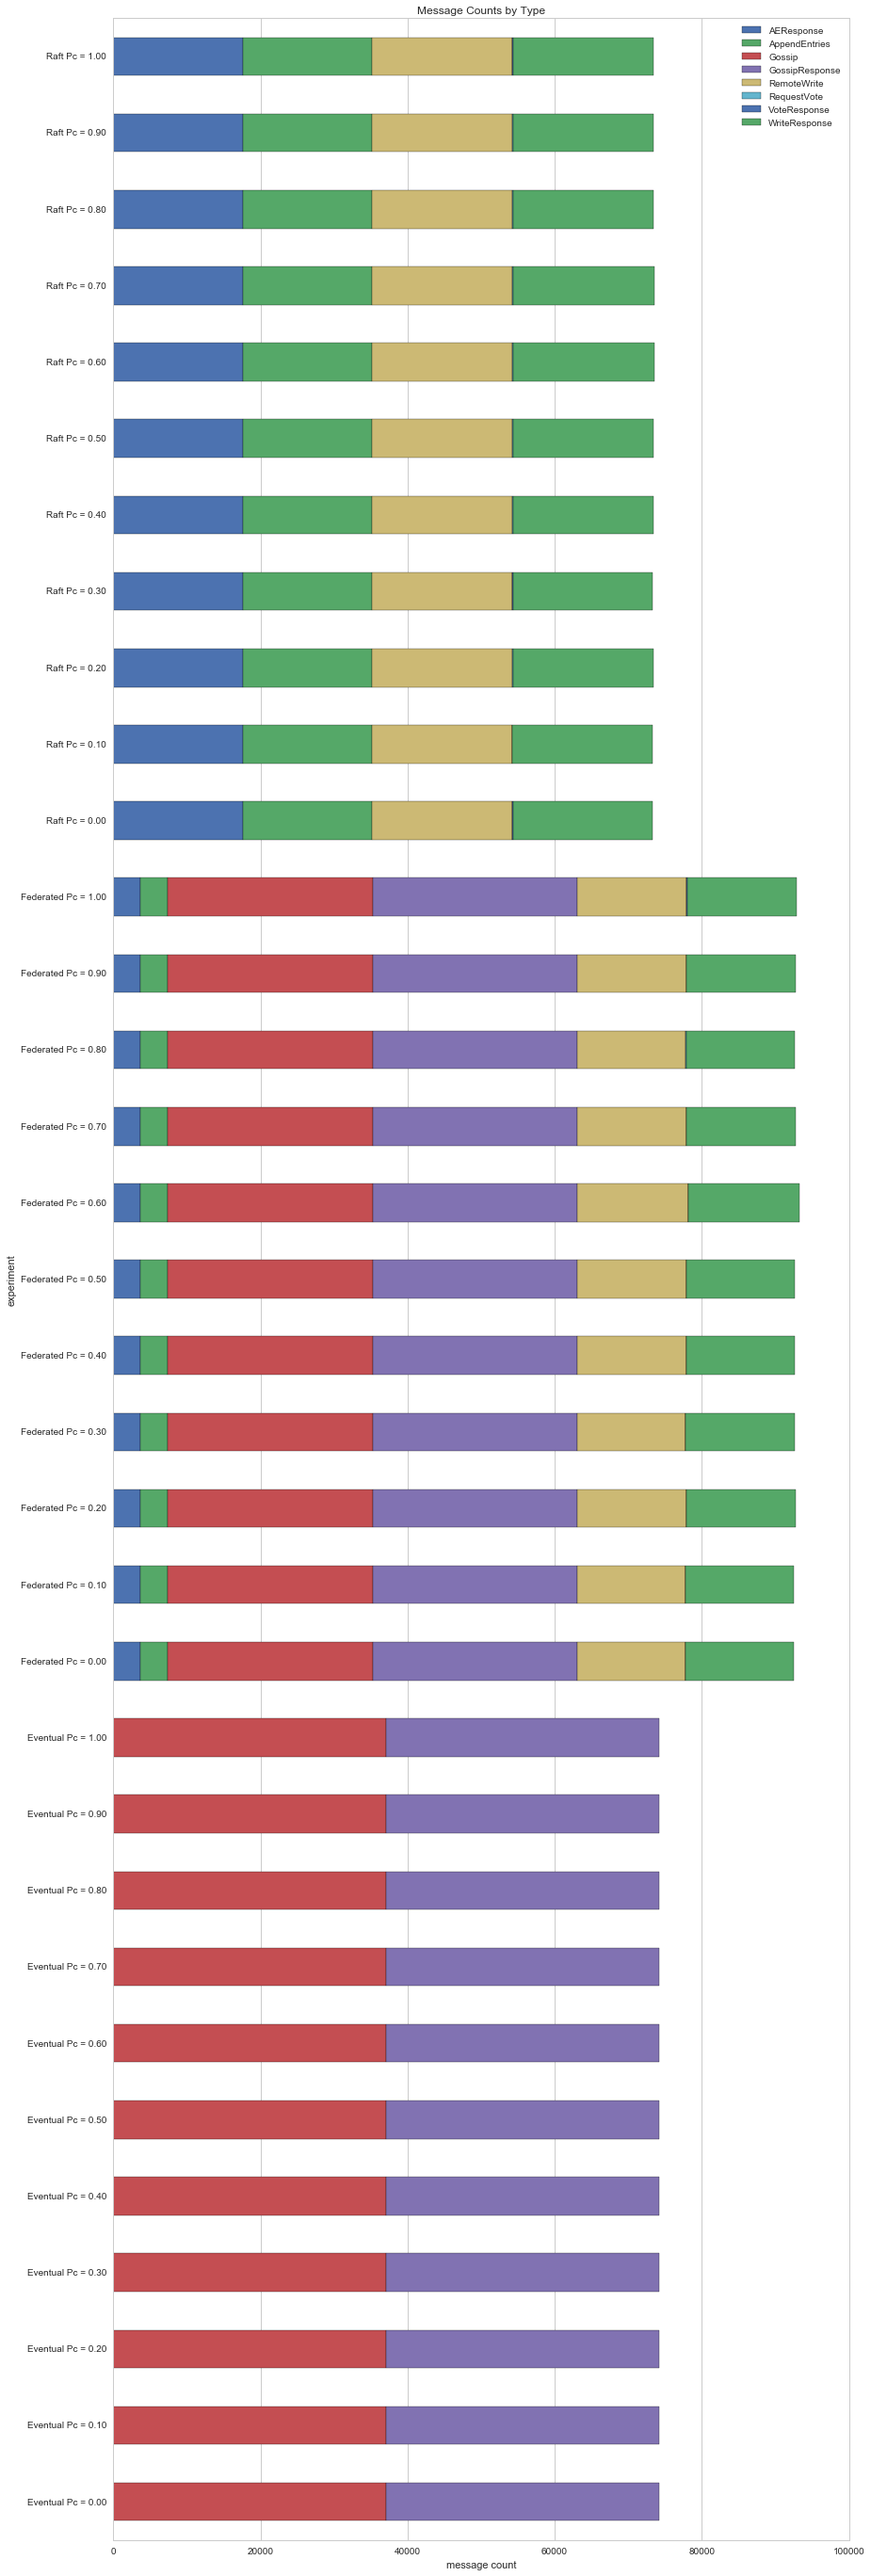

In [39]:
%%memit

def get_message_rows(df):
    for row in df[['message types', 'tick metric (T)', 'type', 'eid', 'users', 'T parameter model', 'conflict probability']].itertuples(): 
        item = row[1]
#         item['experiment'] = "{} {} users ({}) Pc = {:0.2f} T ({}) = {: <6}".format(row[3], row[5], row[4], row[7], row[6], row[2])
        item['experiment'] = "{} Pc = {:0.2f}".format(row[3], row[7])
        yield item

# Create the data frame 
msgs = pd.DataFrame(sorted(get_message_rows(df), key=lambda item: item['experiment']))

# Create the figure 
fig = plt.figure(figsize=(14,48))
ax  = fig.add_subplot(111)
mpl.rcParams.update({'font.size': 22})

# Plot the bar chart 
g = msgs.plot(
    x='experiment', kind='barh', stacked=True, ax=ax, 
    title="Message Counts by Type", color=sns.color_palette()
)

# Modify the figure 
ax.set_xlabel("message count")
ax.yaxis.grid(False)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'message_counts.png'))

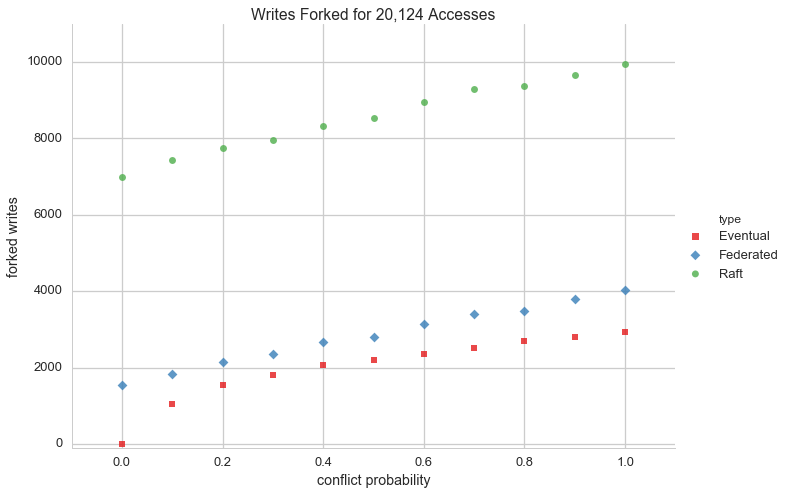

In [104]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
# g = sns.lmplot(
#     x="mean latency (ms)", y="forked writes", hue='type',
#     data=df, fit_reg=False, size=7, aspect=1.4
# )

g = sns.lmplot(
    x="conflict probability", y="forked writes", hue='type',
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["s","D","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Writes Forked for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
# g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100, 11000)
#     ax[0].set_xlim(0, 3000)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'forked_writes.png'))

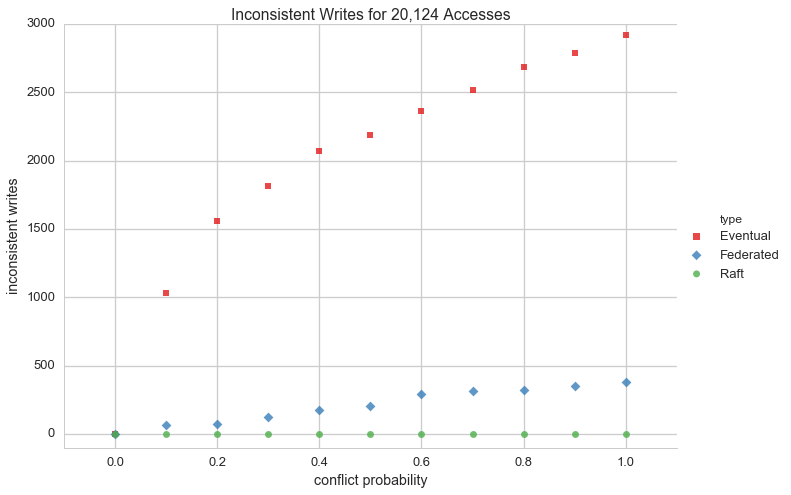

In [105]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
# g = sns.lmplot(
#     x="mean latency (ms)", y="inconsistent writes", hue='ename', row='type',
#     data=df, fit_reg=False, size=7, aspect=1.4
# )

g = sns.lmplot(
    x="conflict probability", y="inconsistent writes", hue='type',
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["s","D","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Inconsistent Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
# g.ax.set_xlabel("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100, 3000)
#     ax[0].set_xlim(0, 3000)
    ax[0].set_xlim(-0.1, 1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'inconsistent_writes.png'))

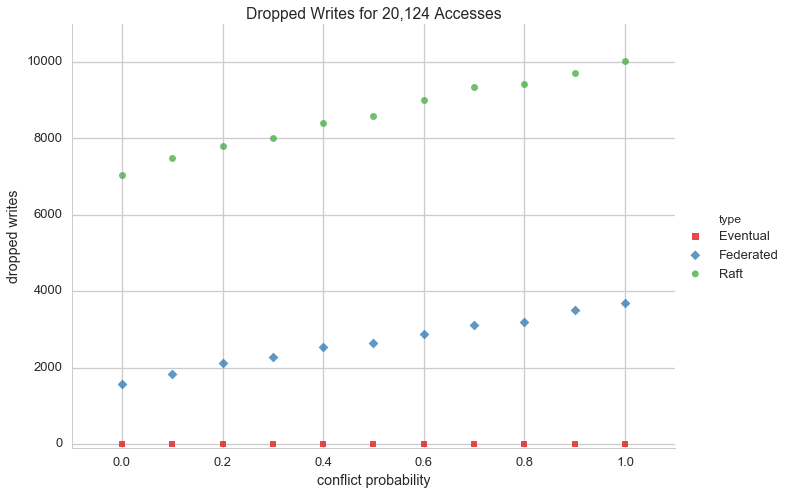

In [106]:
# Dropped Writes
# g = sns.lmplot(
#     x="mean latency (ms)", y="dropped writes", hue='ename', row='type', 
#     data=df, fit_reg=False, size=7, aspect=1.4
# )

g = sns.lmplot(
    x="conflict probability", y="dropped writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["s","D","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Dropped Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
# g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100, 11000)
#     ax[0].set_xlim(0, 3000)
    ax[0].set_xlim(-0.1, 1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'dropped_writes.png'))

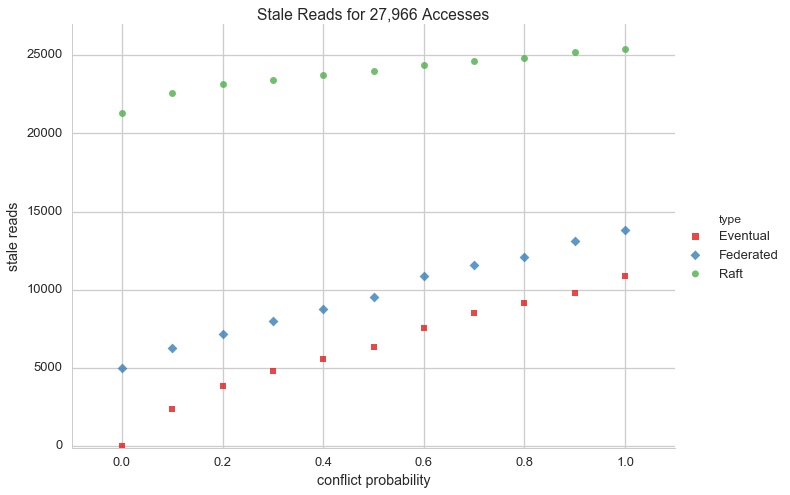

In [107]:
# Stale Reads
# g = sns.lmplot(
#     x="mean latency (ms)", y="stale reads", hue='ename', row='type', 
#     data=df, fit_reg=False, size=7, aspect=1.4
# )

g = sns.lmplot(
    x="conflict probability", y="stale reads", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["s","D","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Stale Reads for {:,} Accesses".format(df.reads.max())
g.ax.set_title(title_fmt)
# g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100, 27000)
#     ax[0].set_xlim(0, 3000)
    ax[0].set_xlim(-0.1, 1.1)
    

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'stale_reads.png'))

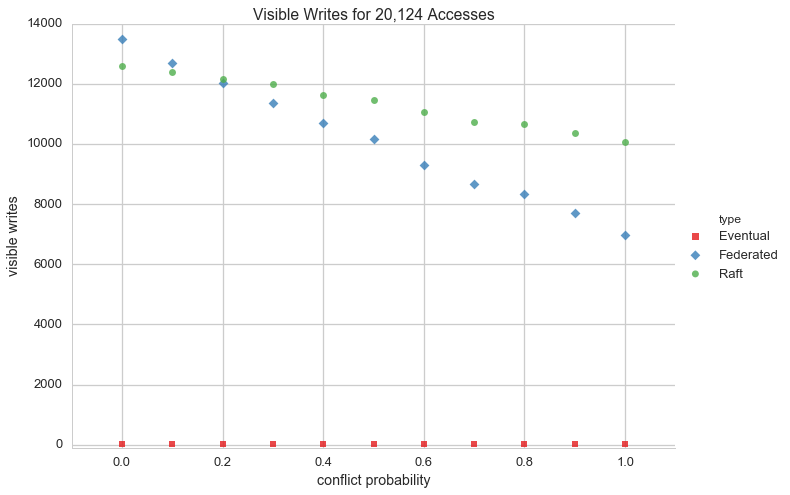

In [108]:
# Visible Writes
# g = sns.lmplot(
#     x="mean latency (ms)", y="visible writes", hue='ename', row='type', 
#     data=df, fit_reg=False, size=7, aspect=1.4
# )

g = sns.lmplot(
    x="conflict probability", y="visible writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["s","D","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Visible Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
# g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100, 14000)
#     ax[0].set_xlim(0, 3000)
    ax[0].set_xlim(-0.1, 1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'visible_writes.png'))

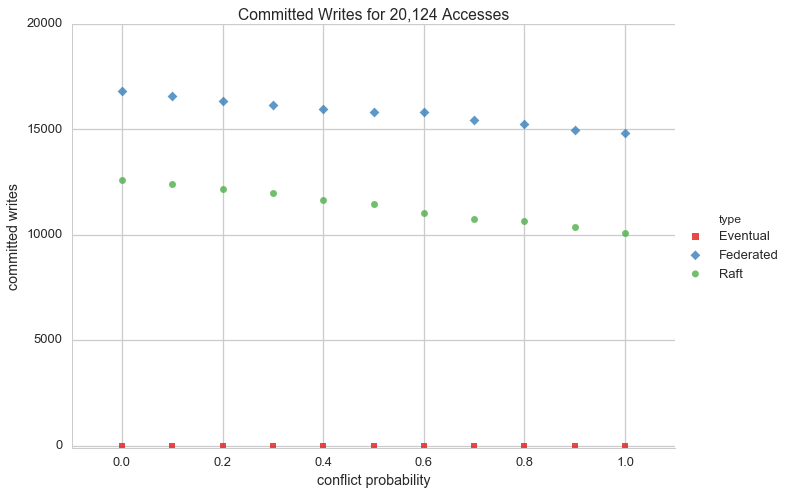

In [109]:
# Comitted Writes
# g = sns.lmplot(
#     x="mean latency (ms)", y="committed writes", hue='ename', row='type', 
#     data=df, fit_reg=False, size=7, aspect=1.4
# )

g = sns.lmplot(
    x="conflict probability", y="committed writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["s","D","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Committed Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
# g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100, 20000)
#     ax[0].set_xlim(0, 3000)
    ax[0].set_xlim(-0.1, 1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'committed_writes.png'))

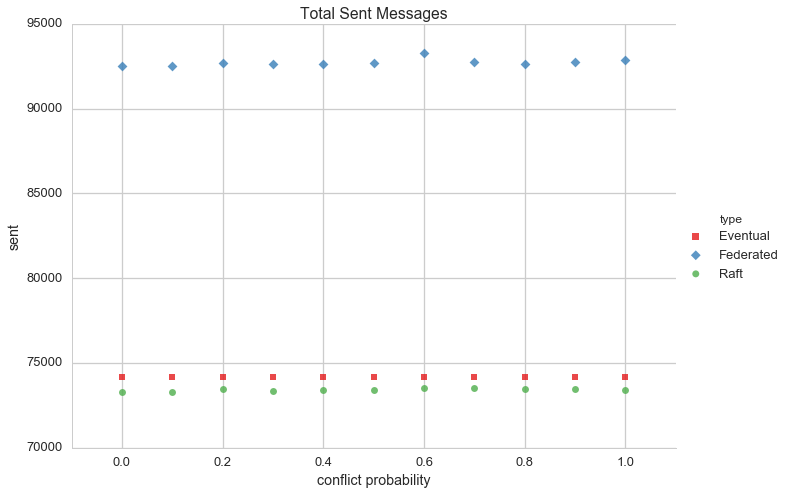

In [110]:
# Number of Messages 
# g = sns.lmplot(
#     x="mean latency (ms)", y="sent", hue='ename', row='type', 
#     data=df, fit_reg=False, size=7, aspect=1.4
# )

g = sns.lmplot(
    x="conflict probability", y="sent", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["s","D","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Total Sent Messages"
g.ax.set_title(title_fmt)
# g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
#     ax[0].set_ylim(-100, 95000)
#     ax[0].set_xlim(0, 3000)
    ax[0].set_xlim(-0.1, 1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'messages_sent.png'))

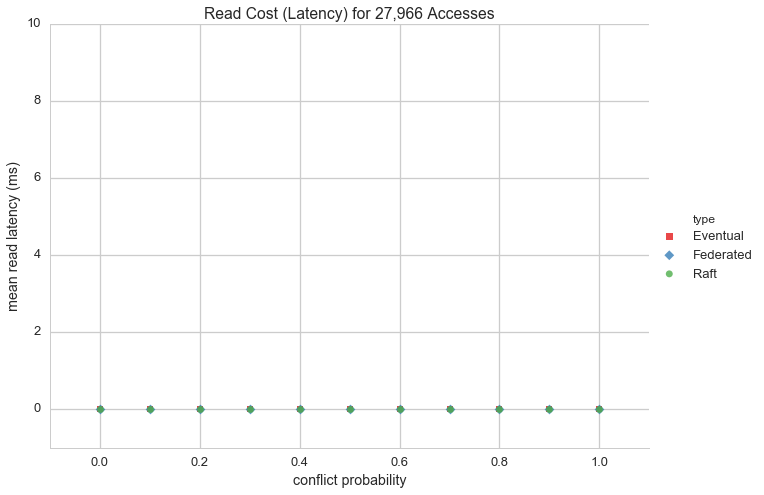

In [111]:
# Read cost (ms delay before read)
# g = sns.lmplot(
#     x="mean latency (ms)", y="mean read latency (ms)", hue='ename', row='type', 
#     data=df, fit_reg=False, size=7, aspect=1.4,
# )

g = sns.lmplot(
    x="conflict probability", y="mean read latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["s","D","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Read Cost (Latency) for {:,} Accesses".format(df.reads.max())
g.ax.set_title(title_fmt)
# g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-1, 10)
    ax[0].set_xlim(0, 3000)
    ax[0].set_xlim(-0.1, 1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'read_latency.png'))

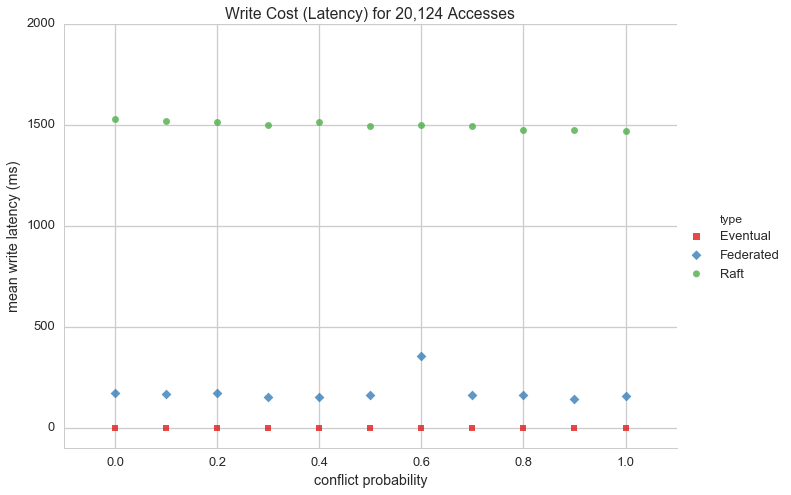

In [112]:
# Write Cost (ms delay before write)
# g = sns.lmplot(
#     x="mean latency (ms)", y="mean write latency (ms)", hue='ename', row='type', 
#     data=df, fit_reg=False, size=7, aspect=1.4,
# )

g = sns.lmplot(
    x="conflict probability", y="mean write latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["s","D","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Write Cost (Latency) for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
# g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100, 2000)
#     ax[0].set_xlim(0, 3000)
    ax[0].set_xlim(-0.1, 1.1)


# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'write_latency.png'))

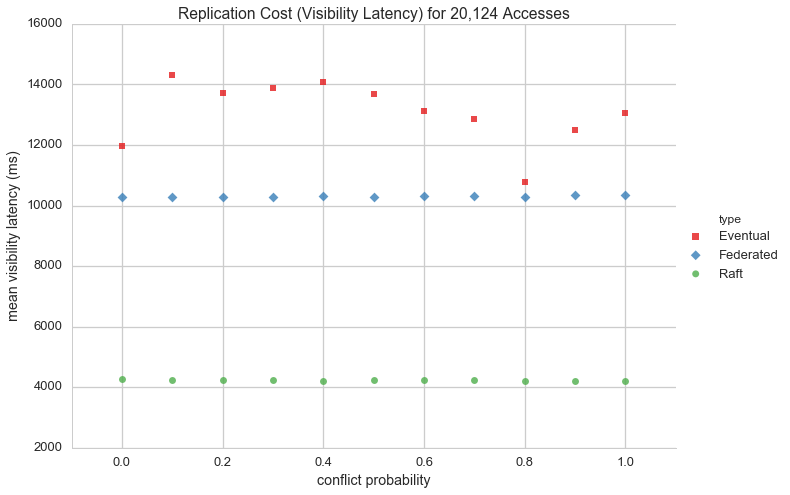

In [113]:
# Replication Cost (Visibility Latency)
# g = sns.lmplot(
#     x="mean latency (ms)", y="mean visibility latency (ms)", hue='ename', row='type', 
#     data=df, fit_reg=False, size=7, aspect=1.4
# )

g = sns.lmplot(
    x="conflict probability", y="mean visibility latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["s","D","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Replication Cost (Visibility Latency) for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
# g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
#     ax[0].set_ylim(0, 50000)
#     ax[0].set_xlim(0, 3000)
    ax[0].set_xlim(-0.1, 1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'visibility_latency.png'))

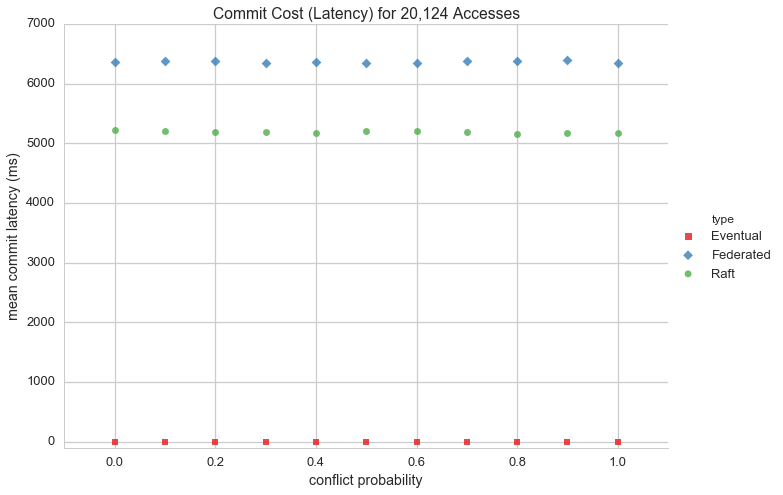

In [114]:
# Commit Cost (Commit Latency)
# g = sns.lmplot(
#     x="mean latency (ms)", y="mean commit latency (ms)", hue='ename', row='type', 
#     data=df, fit_reg=False, size=7, aspect=1.4
# )

g = sns.lmplot(
    x="conflict probability", y="mean commit latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["s","D","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Commit Cost (Latency) for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)
# g.set_xlabels("mean wide area latency (ms)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100, 7000)
#     ax[0].set_xlim(0, 3000)
    ax[0].set_xlim(-0.1, 1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'commit_latency.png'))

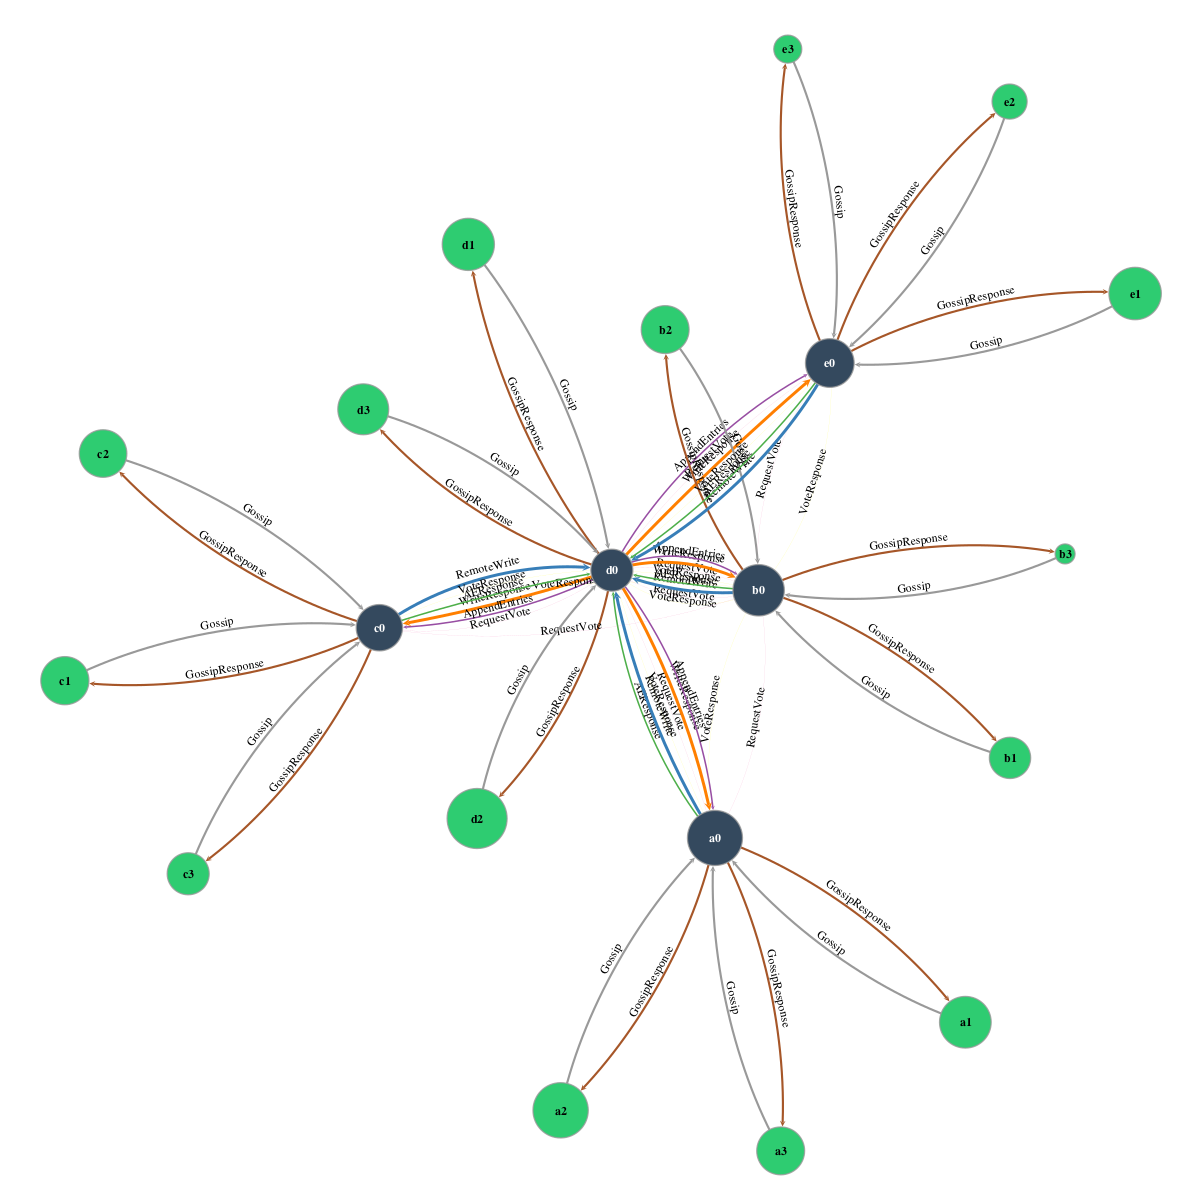

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x11d423710, at 0x11e41d6d0>

In [115]:
def find_results(etype='federated', tick=None):
    for result in get_results_data():
        if result.settings['type'] == etype: 
            if (tick and result.settings['tick_metric'] == tick) or tick is None:
                name = "{}-T{}.png".format(etype, tick)
                return result, name    
    return None, None 


# Find the desired results 
result, name = find_results('federated')
if result is None: raise ValueError("Could not find results!")

# Extract the Graph Tool graph     
G = extract_graph(result, by_message_type=True)

# Draw the graph 
vlabel  = G.vp['id']
vsize   = G.vp['writes']
vsize   = gt.prop_to_size(vsize, ma=60, mi=20)

# Set the vertex color 
vcolor  = G.new_vertex_property('string') 
vcmap   = ColorMap('flatui', shuffle=False)
for vertex in G.vertices():
    vcolor[vertex] = vcmap(G.vp['consistency'][vertex])

# Set the edge color 
ecolor  = G.new_edge_property('string')
ecmap   = ColorMap('set1', shuffle=False)
for edge in G.edges():
    ecolor[edge] = ecmap(G.ep['label'][edge])

elabel  = G.ep['label']
esize   = G.ep['norm']
esize   = gt.prop_to_size(esize, mi=.1, ma=3)
eweight = G.ep['weight']

gt.graph_draw(
    G, output_size=(1200,1200), output=os.path.join(FIGURES, name),
    vertex_text=vlabel, vertex_size=vsize, vertex_font_weight=1, 
    vertex_pen_width=1.3, vertex_fill_color=vcolor,
    edge_pen_width=esize, edge_color=ecolor, edge_text=elabel
)